In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBP92LK/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBP92LK/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBP92LK/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb["train"], imdb["test"]

In [4]:
print(train_data)

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [5]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

In [6]:
training_sentences[1]

"b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.'"

In [7]:
import numpy as np
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [8]:
training_labels_final

array([0, 0, 0, ..., 0, 0, 1])

In [9]:
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [10]:
reverse_word_index = {value:key for key, value in word_index.items()}
def decode_review(text):
  return ' '.join([reverse_word_index.get(i,'?') for i in text])

In [11]:
print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? b'this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received '
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'


In [12]:
embedding_dim = 16
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embedding_dim = 16
model2 = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
num_epochs = 10
model2.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 10s 8ms/step - loss: 0.5240 - accuracy: 0.7614 - val_loss: 0.3674 - val_accuracy: 0.8495
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2987 - accuracy: 0.8795 - val_loss: 0.3211 - val_accuracy: 0.8612
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2413 - accuracy: 0.9056 - val_loss: 0.3237 - val_accuracy: 0.8601
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2088 - accuracy: 0.9208 - val_loss: 0.3449 - val_accuracy: 0.8526
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1847 - accuracy: 0.9318 - val_loss: 0.3538 - val_accuracy: 0.8518
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1657 - accuracy: 0.9414 - val_loss: 0.3765 - val_accuracy: 0.8479
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.1490 - accuracy: 0.9484 - val_loss: 0.4049 - val_accuracy: 0.8439
Epoch

In [ ]:
e = model2.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

import io # input/output
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size): # 10000
   word = reverse_word_index[word_num]
   embeddings = weights[word_num]
   out_m.write(word + '\n')
   out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()

(10000, 16)


In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# IMDB 2.0

In [ ]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info = True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCXD4VN/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCXD4VN/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCXD4VN/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [ ]:
len(tokenizer.subwords)

7928

In [ ]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [ ]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [ ]:
import tensorflow as tf
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 10s 17ms/step - loss: 0.6904 - accuracy: 0.5293 - val_loss: 0.6727 - val_accuracy: 0.7190
Epoch 2/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5763 - accuracy: 0.7664 - val_loss: 0.4821 - val_accuracy: 0.8229
Epoch 3/10
391/391 [==============================] - 7s 16ms/step - loss: 0.3964 - accuracy: 0.8608 - val_loss: 0.3767 - val_accuracy: 0.8578
Epoch 4/10
391/391 [==============================] - 7s 17ms/step - loss: 0.3136 - accuracy: 0.8893 - val_loss: 0.3348 - val_accuracy: 0.8731
Epoch 5/10
391/391 [==============================] - 7s 16ms/step - loss: 0.2717 - accuracy: 0.9041 - val_loss: 0.3272 - val_accuracy: 0.8704
Epoch 6/10
391/391 [==============================] - 7s 16ms/step - loss: 0.2436 - accuracy: 0.9152 - val_loss: 0.3110 - val_accuracy: 0.8769
Epoch 7/10
391/391 [==============================] - 7s 17ms/step - loss: 0.2238 - accuracy: 0.9202 - val_loss: 0.3065 - val_accuracy: 0.881

In [ ]:
history.history

{'accuracy': [0.5292800068855286,
  0.7663599848747253,
  0.860759973526001,
  0.8892800211906433,
  0.9041200280189514,
  0.9151999950408936,
  0.9202399849891663,
  0.925279974937439,
  0.9315999746322632,
  0.936680018901825],
 'loss': [0.6903839707374573,
  0.5762593150138855,
  0.39641594886779785,
  0.31360894441604614,
  0.2716768682003021,
  0.24355800449848175,
  0.22381435334682465,
  0.20737521350383759,
  0.19414685666561127,
  0.18199732899665833],
 'val_accuracy': [0.7189599871635437,
  0.8228800296783447,
  0.8578400015830994,
  0.8730800151824951,
  0.8704000115394592,
  0.8768799901008606,
  0.8810799717903137,
  0.8748000264167786,
  0.8733999729156494,
  0.8794800043106079],
 'val_loss': [0.6726979613304138,
  0.4820671081542969,
  0.37673234939575195,
  0.33482375741004944,
  0.3271808922290802,
  0.3109690845012665,
  0.3064558804035187,
  0.31449684500694275,
  0.324091374874115,
  0.31317391991615295]}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'v' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'l' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support '_' instances.
A proxy artist may be used instead.
See: http:/

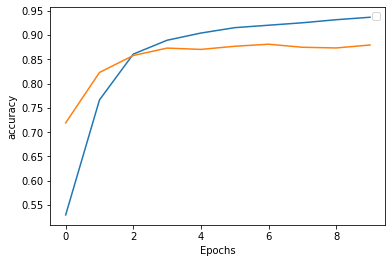

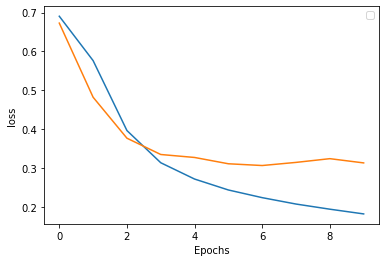

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend('val_', string)
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Sequence models

In [10]:
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [11]:

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, 64),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 714,369
Trainable params: 714,369
Non-trainable params: 0
_________________________________________________________________
